Прогноз роста ВВП G7 vs БРИКС 2025-2030

Гипотеза: БРИКС обгонит G7 по темпам роста ВВП к 2030 году. Проверяем на данных Всемирного банка + прогноз CAGR + линейная регрессия.

Набор данных (датасет): Annual GDP growth, 1980 to 2030, https://www.kaggle.com/datasets/sndorburian/annual-gdp-growth-1980-to-2030

1. Импорт библиотек и загрузка данных

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette("deep")

df = pd.read_csv('real-gdp-growth.csv')
print(f"Размер: {df.shape}")
print("\nКолонки:", df.columns.tolist())
print("\nСтраны в датасете:", df['Entity'].nunique())

Размер: (9620, 7)

Колонки: ['Entity', 'Code', 'Year', 'Gross domestic product, constant prices - Percent change - Observations', '1120034-annotations', 'Gross domestic product, constant prices - Percent change - Forecasts', '1120032-annotations']

Страны в датасете: 207


2. EDA (разведочный анализ данных) - G7 и БРИКС

In [265]:
g7_countries = ['United States', 'Japan', 'Germany', 'United Kingdom', 'France', 'Italy', 'Canada']
brics_countries = ['Brazil', 'China', 'Egypt', 'Ethiopia', 'India', 'Indonesia', 'Iran', 'Russia', 'South Africa', 'United Arab Emirates']

growth_history_col = 'Gross domestic product, constant prices - Percent change - Observations'

g7_df = df[df['Entity'].isin(g7_countries)].copy()
brics_df = df[df['Entity'].isin(brics_countries)].copy()

for dataset in [g7_df, brics_df]:
    dataset['Year'] = dataset['Year'].astype(int)
    dataset['GDP_growth'] = pd.to_numeric(dataset[growth_history_col], errors='coerce')
    
    # ПРИЗНАКИ
    dataset['lag1'] = dataset.groupby('Entity')['GDP_growth'].transform(lambda x: x.shift(1))
    dataset['lag2'] = dataset.groupby('Entity')['GDP_growth'].transform(lambda x: x.shift(2))
    dataset['trend'] = dataset.groupby('Entity')['Year'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
    dataset['volatility'] = dataset\
        .groupby('Entity')['GDP_growth']\
            .transform(lambda x: x.rolling(5, min_periods=1).std().fillna(0))
    
    # Выбросы
    mean_g, std_g = dataset['GDP_growth'].mean(), dataset['GDP_growth'].std()
    dataset['clean_growth'] = dataset['GDP_growth'].clip(mean_g-3*std_g, mean_g+3*std_g)

print(f"G7: {len(g7_df.dropna(subset=['clean_growth']))} записей")
print(f"БРИКС: {len(brics_df.dropna(subset=['clean_growth']))} записей")

# Быстрая статистика
print(f"\nG7 (10 лет): {g7_df.tail(10)['GDP_growth'].mean():.1f}%")
print(f"БРИКС (10 лет): {brics_df.tail(10)['GDP_growth'].mean():.1f}%")

G7: 315 записей
БРИКС: 437 записей

G7 (10 лет): 3.6%
БРИКС (10 лет): 5.5%


3. Визуализация исторических трендов

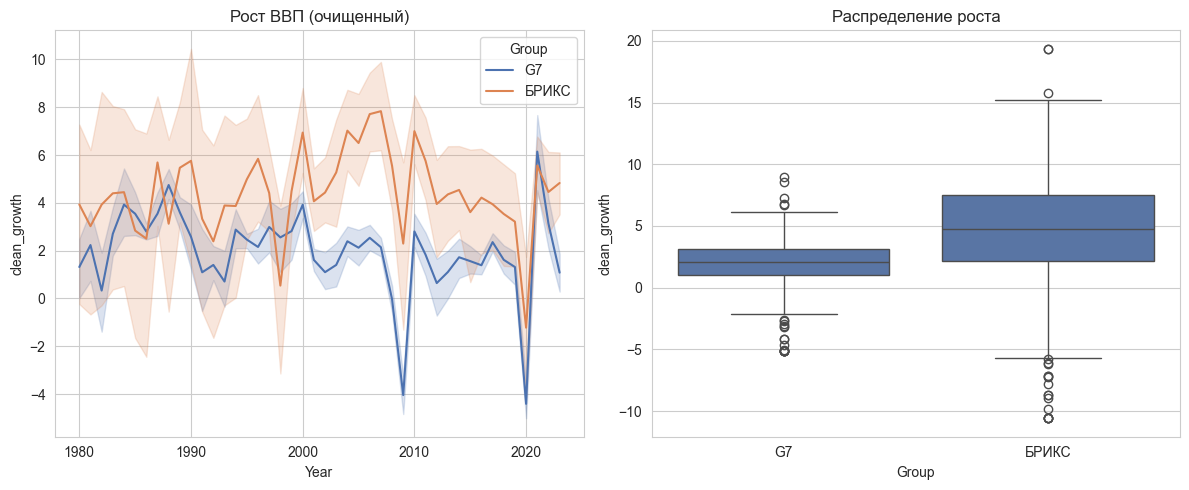

In [266]:
combined_data = pd.concat([
    g7_df[g7_df.Year<=2023].assign(Group='G7'), 
    brics_df[brics_df.Year<=2023].assign(Group='БРИКС')
])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# сглаженный clean_growth
sns.lineplot(data=combined_data, x='Year', y='clean_growth', hue='Group', ax=ax1)
ax1.set_title('Рост ВВП (очищенный)')

# Boxplot: распределение
sns.boxplot(data=combined_data, x='Group', y='clean_growth', ax=ax2)
ax2.set_title('Распределение роста')

plt.tight_layout()
plt.savefig('g7_brics_historical.png', dpi=300)
plt.show()


4. Вычисление совокупного среднегодового темпа роста (Compound annual growth rate, CAGR)

In [267]:
def calculate_cagr(start_value, end_value, periods):
    if start_value <= 0 or periods == 0: return 0
    return (end_value / start_value) ** (1 / periods) - 1

def group_cagr(group_df, years_back=10):
    recent_data = group_df.dropna(subset=['GDP_growth']).tail(years_back)
    if len(recent_data) < 2: return 0
    cum_start = 100
    cum_end = cum_start
    for growth in recent_data['GDP_growth']:
        cum_end *= (1 + growth / 100)
    return calculate_cagr(cum_start, cum_end, len(recent_data) - 1)

g7_cagr = group_cagr(g7_df)
brics_cagr = group_cagr(brics_df)

print(f"CAGR за 10 лет:")
print(f"G7:    {g7_cagr:.2%}")
print(f"БРИКС: {brics_cagr:.2%}")

CAGR за 10 лет:
G7:    2.77%
БРИКС: 2.86%


5. Обучение моделей G7 и БРИКС: случайный лес, линейная регрессия, time series 

In [268]:
def prepare_features(df):
    feats = ['Year', 'lag1', 'lag2', 'trend', 'volatility']
    X = df[feats].dropna()
    y = df.loc[X.index, 'clean_growth'].dropna()
    valid_idx = X.index.intersection(y.index)
    return X.loc[valid_idx], y.loc[valid_idx]

g7_X, g7_y = prepare_features(g7_df)
brics_X, brics_y = prepare_features(brics_df)

print(f"G7: {g7_X.shape} | NaN y: {g7_y.isna().sum()}")
print(f"БРИКС: {brics_X.shape} | NaN y: {brics_y.isna().sum()}")

# случайный лес
rf_g7 = RandomForestRegressor(n_estimators=50, max_depth=4, random_state=42)
rf_brics = RandomForestRegressor(n_estimators=50, max_depth=4, random_state=42)
rf_g7.fit(g7_X, g7_y)
rf_brics.fit(brics_X, brics_y)

# линейная регрессия
lr_g7 = LinearRegression()
lr_brics = LinearRegression()
lr_g7.fit(g7_X[['Year', 'trend']], g7_y)
lr_brics.fit(brics_X[['Year', 'trend']], brics_y)

print("Модели Random Forest и Linear Regression обучены")


G7: (301, 5) | NaN y: 0
БРИКС: (417, 5) | NaN y: 0
Модели Random Forest и Linear Regression обучены


6. Прогноз 2025-2030

In [269]:
def simple_forecast(df, rf_model, lr_model, start_year=2025, end_year=2030, group_name=""):
    # только исторические данные (Year <= 2023)
    hist_data = df[df['Year'] <= 2023].dropna(subset=['clean_growth'])
    
    base_growth = hist_data['clean_growth'].tail(5).mean()  # Последние 5 РЕАЛЬНЫХ лет
    last_vol = hist_data['volatility'].iloc[-1]             # Последняя волатильность
    
    print(f"База {group_name}: {base_growth:.2f}% | Волатильность: {last_vol:.2f}")
    
    forecast = []
    for year in range(start_year, end_year+1):
        future_row = pd.DataFrame({
            'Year': [year],
            'lag1': [base_growth],
            'lag2': [base_growth],
            'trend': [1.0],
            'volatility': [last_vol]
        })
        
        rf_pred = rf_model.predict(future_row)[0]
        lr_pred = lr_model.predict(future_row[['Year', 'trend']])[0]
        
        model_pred = 0.6 * rf_pred + 0.4 * lr_pred
        final_pred = 0.7 * model_pred + 0.3 * base_growth
        
        forecast.append(final_pred)
    
    return pd.DataFrame({'Year': range(start_year, end_year+1), 'Forecast': forecast})

g7_forecast = simple_forecast(g7_df, rf_g7, lr_g7, group_name="G7")
brics_forecast = simple_forecast(brics_df, rf_brics, lr_brics, group_name="БРИКС")

g7_avg = g7_forecast['Forecast'].mean()
brics_avg = brics_forecast['Forecast'].mean()

print(f"\nПРОГНОЗ 2025-2030:")
print(f"G7:    {g7_avg:.2f}%")
print(f"БРИКС: {brics_avg:.2f}%")
print(f"Разница: {brics_avg-g7_avg:+.2f}%")


База G7: 2.42% | Волатильность: 2.94
База БРИКС: 1.79% | Волатильность: 6.26

ПРОГНОЗ 2025-2030:
G7:    1.36%
БРИКС: 2.57%
Разница: +1.21%


7. Визуализация прогнозов

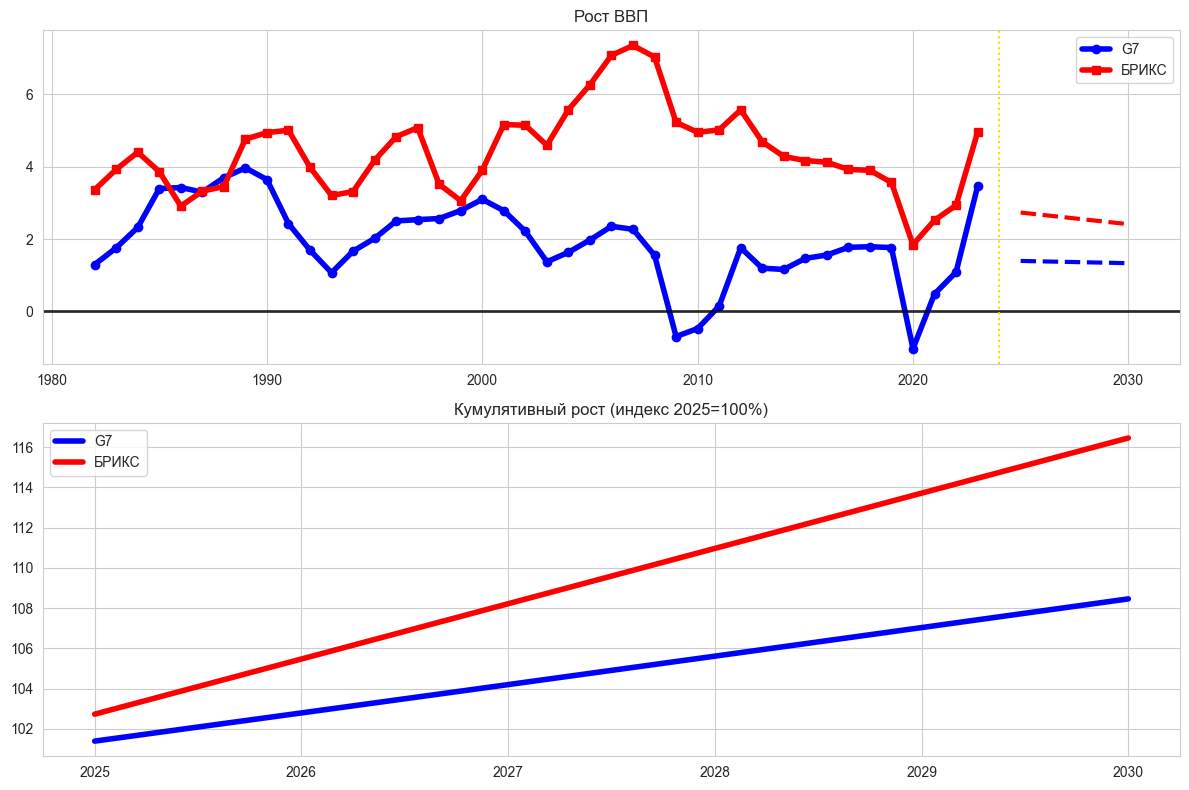

In [270]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 1. рост ВВП
g7_smooth = g7_df[g7_df.Year<=2023].groupby('Year').GDP_growth.mean().rolling(3).mean()
brics_smooth = brics_df[brics_df.Year<=2023].groupby('Year').GDP_growth.mean().rolling(3).mean()
axes[0].plot(g7_smooth, 'b-', lw=4, marker='o', label='G7')
axes[0].plot(brics_smooth, 'r-', lw=4, marker='s', label='БРИКС')
axes[0].plot(g7_forecast.Year, g7_forecast.Forecast, 'b--', lw=3)
axes[0].plot(brics_forecast.Year, brics_forecast.Forecast, 'r--', lw=3)
axes[0].axhline(0, color='black', lw=2, ls='-', alpha=0.8) 
axes[0].axvline(2024, color='gold', ls=':'); axes[0].legend(); axes[0].set_title('Рост ВВП')

# 2. кумулятивный (накопительный) эффект
axes[1].plot(g7_forecast.Year, (1+g7_forecast.Forecast/100).cumprod()*100, 'b-', lw=4, label='G7')
axes[1].plot(brics_forecast.Year, (1+brics_forecast.Forecast/100).cumprod()*100, 'r-', lw=4, label='БРИКС')
axes[1].set_title('Кумулятивный рост (индекс 2025=100%)'); axes[1].legend()

plt.tight_layout(); plt.savefig('g7_brics.png', dpi=300); plt.show()


8. Сводная таблица: прогноз роста ВВП стран G7 и БРИКС 2025-2030

In [271]:
print("\n" + "="*70)
print("G7 vs BRICS GDP GROWTH FORECAST 2025-2030")
print("="*70)
print(f"{'Year':<6} {'G7 %':<8} {'БРИКС %':<10} {'Разница':<10}")

for year in range(2025, 2031):
    g7_val = g7_forecast[g7_forecast['Year'] == year]['Forecast'].iloc[0]
    brics_val = brics_forecast[brics_forecast['Year'] == year]['Forecast'].iloc[0]
    diff = brics_val - g7_val
    print(f"{year:<6} {g7_val:<8.2f} {brics_val:<10.2f} {diff:<10.2f}")

print("="*70)
print(f"{'AVG':<6} {g7_forecast['Forecast'].mean():<8.2f} {brics_forecast['Forecast'].mean():<10.2f} {brics_forecast['Forecast'].mean() - g7_forecast['Forecast'].mean():<10.2f}")
print("="*70)



G7 vs BRICS GDP GROWTH FORECAST 2025-2030
Year   G7 %     БРИКС %    Разница   
2025   1.39     2.73       1.34      
2026   1.38     2.67       1.29      
2027   1.37     2.60       1.23      
2028   1.36     2.54       1.18      
2029   1.34     2.47       1.13      
2030   1.33     2.41       1.08      
AVG    1.36     2.57       1.21      


9. Валидация модели 

In [272]:
tscv = TimeSeriesSplit(n_splits=5)

def cv_metrics_full(X, y, rf_model, lr_model):
    rf_mae, rf_r2, lr_mae, lr_r2 = [], [], [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        rf_model.fit(X_train, y_train)
        lr_model.fit(X_train[['Year', 'trend']], y_train)
        
        rf_pred = rf_model.predict(X_test)
        lr_pred = lr_model.predict(X_test[['Year', 'trend']])
        
        rf_mae.append(mean_absolute_error(y_test, rf_pred))
        rf_r2.append(r2_score(y_test, rf_pred))
        lr_mae.append(mean_absolute_error(y_test, lr_pred))
        lr_r2.append(r2_score(y_test, lr_pred))
    
    return np.mean(rf_mae), np.mean(rf_r2), np.mean(lr_mae), np.mean(lr_r2)

g7_rf_mae, g7_rf_r2, g7_lr_mae, g7_lr_r2 = cv_metrics_full(g7_X, g7_y, 
    RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42), LinearRegression())
brics_rf_mae, brics_rf_r2, brics_lr_mae, brics_lr_r2 = cv_metrics_full(brics_X, brics_y, 
    RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42), LinearRegression())

g7_avg = g7_forecast['Forecast'].mean()
brics_avg = brics_forecast['Forecast'].mean()
diff = brics_avg - g7_avg

print("РЕЗУЛЬТАТЫ:")
print(f"G7 MAE={g7_rf_mae:.2f}% | R²={g7_rf_r2:.3f}\nБРИКС MAE={brics_rf_mae:.2f}% | R²={brics_rf_r2:.3f}")
print(f"\nПРОГНОЗ МОДЕЛИ: G7 {g7_avg:.2f}% | БРИКС {brics_avg:.2f}% | Разница +{diff:.2f}%")


РЕЗУЛЬТАТЫ:
G7 MAE=1.29% | R²=0.296
БРИКС MAE=2.93% | R²=-0.036

ПРОГНОЗ МОДЕЛИ: G7 1.36% | БРИКС 2.57% | Разница +1.21%
